In [4]:
# Design of a Nozzle for HALE Rocket 
# Optimization of Final Altitude, Remain Between 2nd and 3rd Critical point 
# Assume isentropic flow between normal shocks: all losses in nozzle occur across the normal shock

# Author: Jacob van de Lindt 
# August 2019

# FGD refers to "Fundamentals of Gas Dynamics" by Robert D. Zucker and Oscar Biblarz, 2nd Edition 

In [16]:
# Imports and Definitions of constants and knows 

# Imports
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

# Constants 
k = 1.226                                 # Cp/Cv for HALE Kerosene/Oxygen Mixture Ratio
Rbar = 8314                               # [J/K-mol] universal gas constant
R = 389.4145                              # [J/kgK] for the fuel/oxidizer mixture
R_air = 287.05287                         # [J/kgK] for dry air
g_c = 1                                   # [m/s^2]
g_0 = 9.81                                # [m/s^2] gravitational constant at sea level
A_c = np.pi * (0.1524/2)**2               # [m^2] cross sectional area of HALE Rocket (6 inch D)
wet_mass = 68.0389                        # [kg]
# Knowns 
m_dot = 3.501733                          # mass flow rate, [kg/s]. Assumed constant

# Knowns at station 1, inside combustion chamber 
M_1 = 0
T_1 = 3600                                # [K] adiabatic flame temperature 
P_1 = 2.413e6                             # [Pa] chamber pressure 
D_1 = 0.1397                              # [m] The combustion chamber diameter 
A_1 = (1/4)*np.pi*D_1**2                  # [m^2]
# Define first stagnation conditions (from combustion chamber to shock) as station 1 knowns 
T_t1 = T_1
P_t1 = P_1

In [7]:
# Define enviroment conditions at altitude 
def g_grav(alt):
                               # Takes an altitude in meters and 
                               # returns the gravitation acceleration  
    G = 6.674*10**(-11)        # m^3 / (kg s^2)
    M_earth = 5.972e24         # kg
    r_earth = 6371000          # m
    return G * M_earth / (alt + r_earth)**2 

def T_at_alt(alt):
                               # Enter an altitude in [m] and it 
                               # will output the temperature in [K] at this alt 
    alt_km = alt / 1000        # convert to [Km]
    # Use conditionals for lapse rates. 
    # Values from https://www.translatorscafe.com/unit-converter/en-US/calculator/altitude/
    
    if alt_km < 11:
        L_b = -6.5
        T_b = 288.15           # [K]
        alt_b = 0              # [km]
    elif alt_km < 20:
        L_b = 0
        T_b = 216.65           # [K]
        alt_b = 11             # [km]
    elif alt_km < 32:
        L_b = 1
        T_b = 216.65           # [K]
        alt_b = 20             # [km]
    elif alt_km < 47:
        L_b = 2.8
        T_b = 228.65           # [K]
        alt_b = 32             # [km]
    elif alt_km < 51:
        L_b = 0
        T_b = 270.65           # [K]
        alt_b = 47             # [km]
    elif alt_km < 71:
        L_b = -2.8
        T_b = 270.65           # [K]
        alt_b = 51             # [km]
    elif alt_km <= 84.9:
        L_b = -2
        T_b = 214.65           # [K]
        alt_b = 71             # [km]
    else:
        return('Error: Atmosphere Air Temp Not Valid Beyond 84.9 km')
    T_alt = T_b + L_b*(alt_km - alt_b)
    return T_alt 
                                               # vectorize the function for use with numpy arrays  
v_T_at_alt = np.vectorize(T_at_alt)

def P_at_alt(alt):
                                               # Enter an altitude in [m] and it will 
                                               # output the pressure in [Pa] at this alt 
    alt_km = alt / 1000                        # convert to [Km]
                                               # Use conditionals for lapse rates. 
    # Values from https://www.translatorscafe.com/unit-converter/en-US/calculator/altitude/
    if alt_km < 11:
        L_b = -6.5
        T_b = 288.15           # [K]
        alt_b = 0              # [km]
        P_b = 101325           # [Pa]
    elif alt_km < 20:
        L_b = 0
        T_b = 216.65           # [K]
        alt_b = 11             # [km]
        P_b = 22632.06         # [Pa] 
    elif alt_km < 32:
        L_b = 1
        T_b = 216.65           # [K]
        alt_b = 20             # [km]
        P_b = 5474.889         # [Pa]
    elif alt_km < 47:
        L_b = 2.8
        T_b = 228.65           # [K]
        alt_b = 32             # [km]
        P_b = 868.0187         # [Pa]
    elif alt_km < 51:
        L_b = 0
        T_b = 270.65           # [K]
        alt_b = 47             # [km]
        P_b = 110.9063         # [Pa]
    elif alt_km < 71:
        L_b = -2.8
        T_b = 270.65           # [K]
        alt_b = 51             # [km]
        P_b = 66.93887         # [Pa]
    elif alt_km <= 84.9:
        L_b = -2
        T_b = 214.65           # [K]
        alt_b = 71             # [km]
        P_b = 3.956420         # [Pa]
    else:
        return 'error'
    if L_b != 0:
        L_b_per_m = L_b / 1000                          # convert to [K/m]
        base = T_b / v_T_at_alt(alt)
        exponant = g_0 / (R_air * L_b_per_m)
        P_alt = P_b * base**exponant
    else:
        exponant = (g_0 * (alt - alt_b*1000)) / (R_air * T_b)
        P_alt = P_b * np.exp(-exponant)
    return P_alt
                                                    # Enter an altitude in [m] and it will 
                                                    # return the pressure at this altitude in [Pa]
                                                    # Can be used up to 86 Alt = Km. 
    
# vectorize the function for use with numpy arrays  
v_P_at_alt = np.vectorize(P_at_alt)    

def density_at_alt(alt):
    # Use existing pressure and temp functions along with eq of state for a perfect gas
    if alt <= 84900:   #[m]
        return v_P_at_alt(alt) / (R_air * v_T_at_alt(alt))
    else:
        return alt*0

# vectorize the function for use with numpy arrays  
v_density_at_alt = np.vectorize(density_at_alt) 

In [8]:
# Define Isentropic Relations and Normal Shock Property Changes

def T_over_T_stag(M, k):
    # Isentropic Relation (Eq. (4.18), FGD)
    return ( 1 + ((k - 1) / 2)*M**2 )**(-1)

def A_over_A_star(M, k):
    # Isentropic Relation (Eq. (5.37), FGD) 
    # Takes in the mach number and heat capacity ratio and returns the area ratio
    term_1 = 1 / M
    numerator = 1 + ( (k - 1) / 2)*M**2
    denominator = ( k + 1) / 2
    term_2 = numerator / denominator
    power = ( k + 1 ) / (2*(k - 1))
    return term_1 * term_2**power

def p_over_p_stag(M, k):
    # Isentropic Relation (Eq. (5.40) FGD) 
    # Takes in the mach number and heat capacity ratio and returns the pressure ratio
    # p / p_stagnation 
    base = 1 / (1 + ( (k - 1) / 2)*M**2 )
    power = k / (k - 1)
    return base**power

# The next two functions are used to determine the mach number at a station if the
# stagnation pressure vs. stagnation pressure ratio and area ratio are known. Iteration is used. 
# The initial mach number guess must be in the correct regime (supersonic or subsonic)

def get_M_helper_1(M_guess, A_P_ratio, k):
    # M_guess is the guessed mach number, must be in correct mach regime
    # A_P_ratio is A/A* times p/p_stagnation 
    C = (k+1)/2
    D = (k-1)/2
    J = (k+1)/(2*k-2)
    W = k/(k-1)
    return (1/A_P_ratio) * (( (1 + D*M_guess**2)/C )**J) * ((1 / (1 + D*M_guess**2))**W)

def get_M_given_Ar_Pr(M_guess, A_P_ratio, k):
    # Uses get_M_helper_1 to solve for the mach number with iteration given the product of
    # area and pressure ratios at the station, as well as k and an initial guess for the mach number.
    M = M_guess
    
    # interate for M 
    for i in range(40):
        # It was found that 40 iterations more than insured convergance 
        M = get_M_helper_1(M, A_P_ratio, k)
    return M

# The next two functions accomplish the same outcome as the last two: iteration is used
# to solve for the mach number. However, this set only requires the stagnation pressure
# ratio, as well as k and a guess for M as inputs. 

def get_M_helper_2(M_guess, Pr, k):
    # Returns an estimation for mach number given a guess for mach number, the pressure
    # ratio, and the heat capacity ratio 
    
    # define exponants and factors 
    X = (k+1)/2
    Y = (k-1)/2
    N = k/(k-1)
    T = (2*k)/(k+1)
    Z = (k-1)/(k+1)
    L = 1/(1-k)
    M = M_guess
    inside = (M**2 * X) / (M**2 * Y + 1)
    inside_raised = ( Pr * inside**(-N) ) ** (1/L)
    return np.sqrt( (inside_raised + Z) / T)

def get_M_given_P_t_ratio(M_guess, P_t_ratio, k):
    # Iterate to solve for the mach number given the stagnation pressure ratio
    # across the shock. returns the mach number just before the shock  
    M = M_guess
    
    # iterate and solve for M. 40 iterations was found to have good convergance 
    for i in range(40):
        M = get_M_helper_2(M, P_t_ratio, k)
    return M


# This next set uses iteration and the area ratio to solve for the mach number.
# It is only valid for isentropic flow, and for M > 1. 

def get_M_helper_3(M_new, A_r, k):
    term_1 = M_new * A_r
    C = (k+1)/2
    D = (k-1)/2
    J = (k+1)/(2*k-2)
    term_2 = (term_1 ** (1/J) ) * C - 1
    return np.sqrt( term_2 / D )


def get_M_given_A_r(M_guess, A_r, k):
    M = M_guess
    for i in range(40):
        M = get_M_helper_3(M, A_r, k)
    return M

# Next function returns an area [m^2] given the mach number and stagnation conditions
# For Isentropic flow, Equation (5.44a) FGD
def A_given_M(M, T_t, P_t):
    first = m_dot / M
    power = (k + 1) / (2*(k - 1))
    second = (1 + ( (k - 1)/2 ) * M**2 ) ** (power)
    third = (R / (k*g_c)) ** (1/2)
    fourth = np.sqrt(T_t) / P_t
    
    return first*second*third*fourth

In [9]:
# Define Thrust and Drag Force Functions 

def F_thrust(m_dot, Area_r, A_throat, alt, P_chamber, T_chamber):
    # Takes in the mass flow rate, the expansion ratio, throat area, altitude [m], and chamber 
    # pressure [Pa] and returns the thrust achieved at that altitude, in [N].
    # It is assumed that operation is at least just past second critical 
    # (isentropic flow to end of nozzle). Note that this is justified because in the optimization,
    # no area ratio will be tested that causes operation between first and second crit.
    A_exit = Area_r * A_throat
    
    M_guess = 4 # guess an M > 1 for the exit mach number, then solve with iteration 
    M_exit = get_M_given_A_r(M_guess, Area_r, k)
    
    # Get the exit temperature 
    T_exit = T_chamber * T_over_T_stag(M_exit, k)
    
    # Get exit velocity and exit pressure 

    V_exit = M_exit * np.sqrt(k * R * g_c * T_exit)
    P_exit = P_chamber * p_over_p_stag(M_exit, k)
    
    P_ambient = P_at_alt(alt)
    Thrust = m_dot*V_exit + (P_exit - P_ambient)*A_exit
    return Thrust # [N] 

def F_drag(alt, v):
    # Takes in Altitude and vehicle velocity and outputs the drag force in [N]
    C_d = 2
    rho_alt = v_density_at_alt(alt) # get air density
    
    F_drag = rho_alt * (1/2) * C_d * A_c * v**2
    
    return F_drag

# Determine Maximum Expansion Ratio
#### Using the 2nd critical area ratio at sea level as worst case   

In [10]:
# Calculate throat area given the chamber conditions in [m^2]:
A_throat = A_given_M(1, T_1, P_1) # mach is 1 at the throat
A_2 = A_throat

In [11]:
# Define Shock-In-Nozzle Location Finder 
def find_shock(A_r, P_chamber, P_amb, A_throat):
    # Takes in expansion ratio, chamber pressure, ambient pressure, and throat area and returns the
    # Nozzle Area where the shock occures
    
    A_star_exit_P_t_exit = A_throat * P_chamber  # Adiabadic, no work flow across a shock
                                                 # Note that A_throat is A* preceeding the shock
                                                 # and P_chamber is the stagnation pressure,
                                                 # preceeding the shock. The product of these two 
                                                 # numbers remains constant across the shock. 
    
    M_guess = 1.5                                # Initial guess for iteration
    A_exit  = A_r * A_throat
    P_exit = P_amb
    A_P_Ratio = (A_exit * P_exit) / A_star_exit_P_t_exit 
    M_exit = get_M_given_Ar_Pr(M_guess, A_P_Ratio, k)
    
    
    
    
    P_stag_exit = (1 / ( p_over_p_stag(M_exit, k) )) * P_exit
    
                                                 # The stagnation pressure at the exit is the 
                                                 # same as just after the shock. The stagnation 
                                                 # pressure just before the shock is the chamber
                                                 # pressure. 
                                                 # The mach number just before the shock is a 
                                                 # function of the ratio of the change of 
                                                 # stagnation pressures across the shock
    P_t_rat = P_stag_exit / P_chamber
                                                 # Use the same guess for the mach number to
                                                 # begin iteration
            
    M_3 = get_M_given_P_t_ratio(M_guess, P_t_rat, k)
                                                 # Use this mach number to get the area where the 
                                                 # shock occures
    A_shock = A_throat * A_over_A_star(M_3, k)
    
    return A_shock

In [33]:
# Create two arrays. The first holds the nozzle exit area, given the expansion ratio. 
# The second contains the area of the shock, given the expansion ratio. 
# When these two functions of expansion ratio are equal, it means the shock is located
# at the exit plane and the nozzle is thus at 2nd Critical operation.

P_exit = P_at_alt(0) 
P_chamber = P_1
expansion_ratio_vector = np.arange(1.1, 80, .1)
num_test_ratios = expansion_ratio_vector.shape[0]
shock_area_vector = np.zeros(num_test_ratios)
exit_area_vector = A_throat * expansion_ratio_vector
for i in range(num_test_ratios):
    A_ratio = expansion_ratio_vector[i]
    shock_area_vector[i] = find_shock(A_ratio, P_chamber, P_exit, A_throat)
     

<IPython.core.display.Javascript object>


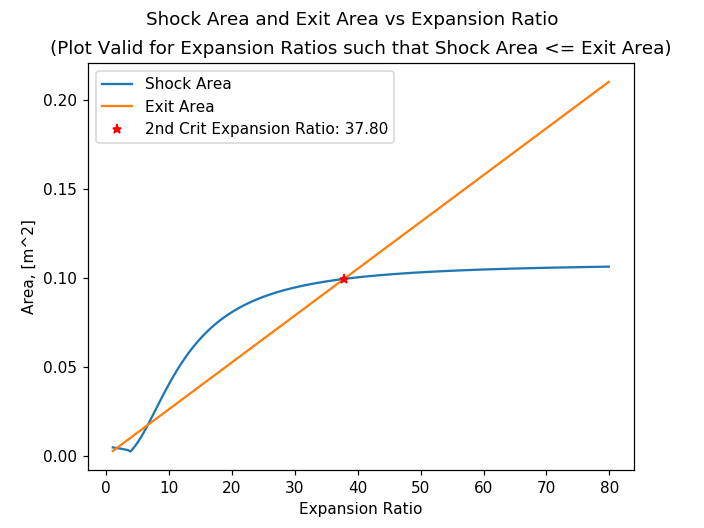

2nd Critical Expansion Ratio: 37.80


In [50]:
# Plot the two functions and locate intersection. Ignore low expansion ratio intersections,
# they are not valid as the shock has left the nozzle at expansion ratios smaller 
# than the first intersection.

# Find Location of 2nd Critical. Only take intersection where shock first moves
# out of nozzle with decresing expansion ratio
idx = np.argwhere(np.diff(np.sign(shock_area_vector - exit_area_vector))).flatten()
idx = max(idx)
second_crit_exp_ratio = expansion_ratio_vector[idx]

# Plot the analysis for locating the shock 
second_crit_label = '2nd Crit Expansion Ratio: %.2f' % second_crit_exp_ratio
plt.plot(expansion_ratio_vector, shock_area_vector, label='Shock Area')
plt.plot(expansion_ratio_vector, exit_area_vector, label='Exit Area')
plt.plot(expansion_ratio_vector[idx], shock_area_vector[idx], 'r*', label=second_crit_label)
plt.title('(Plot Valid for Expansion Ratios such that Shock Area <= Exit Area)')
plt.suptitle('Shock Area and Exit Area vs Expansion Ratio')
plt.xlabel('Expansion Ratio')
plt.ylabel('Area, [m^2]')
plt.plot()
plt.legend()
print('2nd Critical Expansion Ratio: %.2f' % second_crit_exp_ratio)

# Flight Simulation 

In [53]:
def flight_sym(A_ratio, A_throat, burn_time, tot_sym_time, dt, P_chamber, T_chamber):
    # Takes in the nozzle expansion ratio, the throat area, burn time, total simulation time,
    # time differential, chamber pressure, and chamber temperature and runs a flight of
    # the rocket, taking thrust, drag, and gravity forces into acount at each time step. 
    # Returns arrays of altitude, velocity, time, and thrust. 
    A_r = A_ratio
    P_t = P_chamber
    T_t = T_chamber
    
    # initial conditions
    v_0 = 0 # [m/s] 
    y_0 = 0 # [m] initial altitude 

    # Create arrays to hold simulation veloctiy and altitude 
    v_array = np.array([v_0])
    y_array = np.array([y_0])
    t_array = np.array([0])
    thrust_array = np.array([0])


    total_simulation_time = tot_sym_time # duration of simulation, [s]

    # Initialize
    mission_time = 0 # Mission time, updated in simulation [s]
    v = v_0 # [m/s]
    y = y_0 # [m/s]
    rocket_mass = wet_mass # [kg]
    while ((mission_time < total_simulation_time) and (y >= 0)):
        if mission_time <= burn_time:       # only depricate rocket mass if mass is still burning
            mass_burned = m_dot * mission_time
            rocket_mass = wet_mass - mass_burned
        
        F_g = rocket_mass * g_grav(y) # force of gravity on rocker [N]
    
        F_d = F_drag(y, v) # drag force on rocket [N]
    
        if v < 0:          # Switch force direction if the rocket is falling
            F_d = - F_d
    
        # The thrust is zero after the burn time has finished 
        F_t = 0
        if mission_time < burn_time:
            F_t = F_thrust(m_dot, A_r, A_throat, y, P_t, T_t) # thrust force [N]
            
        
        F_net = F_t - F_d - F_g
    
        a_instant = F_net / rocket_mass 
    
        v = v + a_instant * dt        # Update velocity and position based on instant acceleration 
        y = y + v * dt
                                      # update arrays storing the simulation data
        v_array = np.append(v_array, v)
        y_array = np.append(y_array, y)
    
        mission_time += dt            # update mission time 
        t_array = np.append(t_array, mission_time)
        thrust_array = np.append(thrust_array, F_t)
    return  y_array, v_array, t_array, thrust_array 

<IPython.core.display.Javascript object>


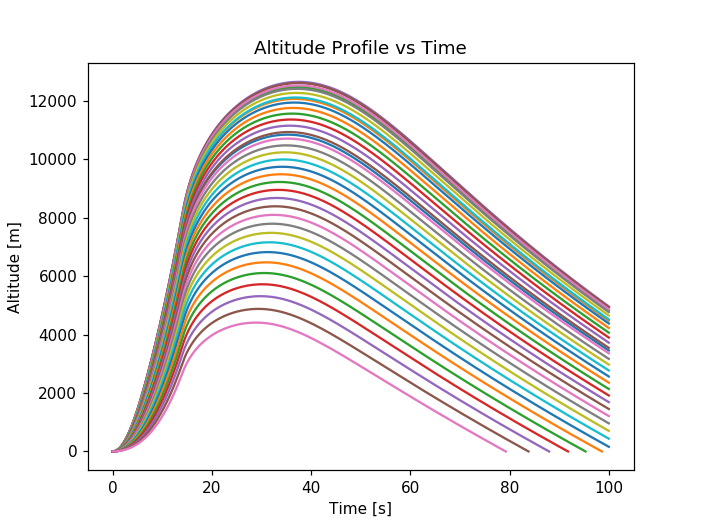

Text(0, 0.5, 'Altitude [m]')

In [57]:
# Run many flight simulations by changing the expansion ratio and seeing the maximum altitude. 

# First create an array of expansion ratios to test. The largest should be the 
# second critical expansion ratio found from the shock analysis, ensuring no shocks are ever
# in the nozzle. Start at an expansion ratio of 1.1 
Expansion_Ratio_Array = np.arange(1.1, second_crit_exp_ratio, 1)
length_of_array = Expansion_Ratio_Array.shape[0]
Max_Alt_Array = np.zeros(length_of_array)

# Plot flights 
for i in range(length_of_array):
    A_R = Expansion_Ratio_Array[i]
    yar, var, tar, far = flight_sym(A_R, A_2, 14, 100, .01, P_1, T_1)
    Max_Alt_Array[i] = np.max(yar)
    plt.plot(tar, yar)
plt.title('Altitude Profile vs Time for Different Expansion Ratios')
plt.xlabel('Time [s]')
plt.ylabel('Altitude [m]')

<IPython.core.display.Javascript object>


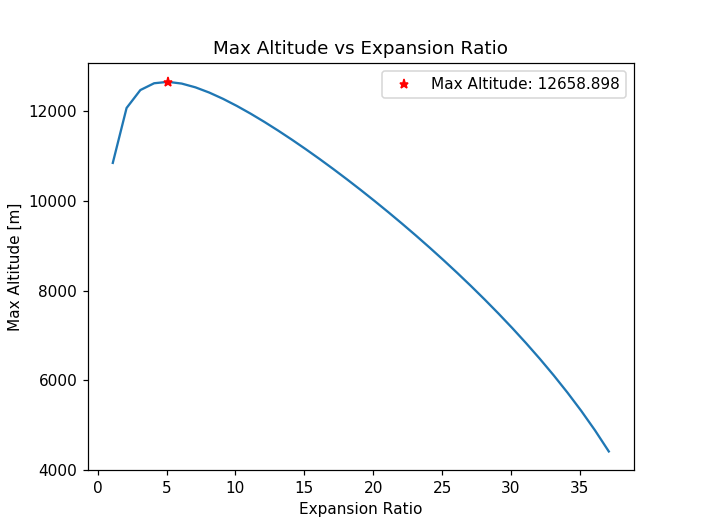

The Optimum Expansion Ratio is: 5.10


In [74]:
# Plot Optimization and Locate Optimum Expansion Ratio 

plt.plot(Expansion_Ratio_Array, Max_Alt_Array)
plt.xlabel('Expansion Ratio')
plt.ylabel('Max Altitude [m]')
plt.title('Max Altitude vs Expansion Ratio')
label_string = 'Max Altitude: %.3f ' % Max_alt

maxindex = np.where(Max_Alt_Array == np.max(Max_Alt_Array))
Max_alt = Max_Alt_Array[maxindex]
plt.plot(Expansion_Ratio_Array[maxindex], Max_alt, 'r*', label=legend_string)
plt.legend()
Optimum_Expansion_Ratio = Expansion_Ratio_Array[maxindex] 

print('The Optimum Expansion Ratio is: %.2f' % Optimum_Expansion_Ratio)

# Plot Atmospheric Properties Used in Simulation.  

<IPython.core.display.Javascript object>


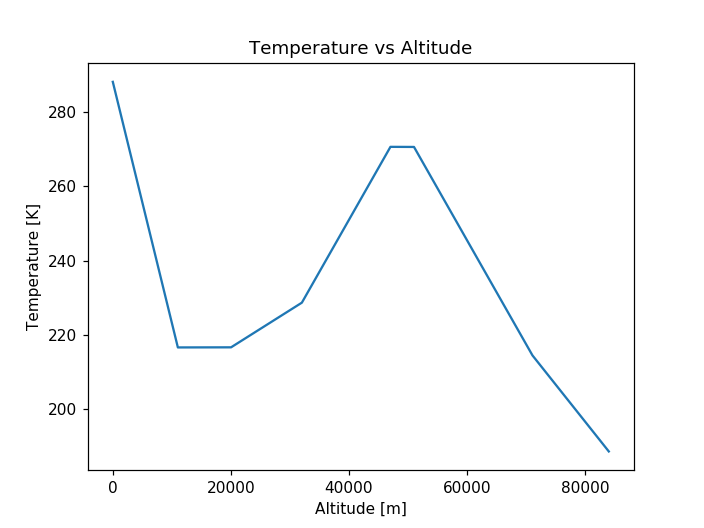

Text(0, 0.5, 'Temperature [K]')

In [77]:
tarray = np.arange(0, 84000, 1)
plt.plot(tarray, v_T_at_alt(tarray))
plt.title('Temperature vs Altitude')
plt.xlabel('Altitude [m]')
plt.ylabel('Temperature [K]')

<IPython.core.display.Javascript object>


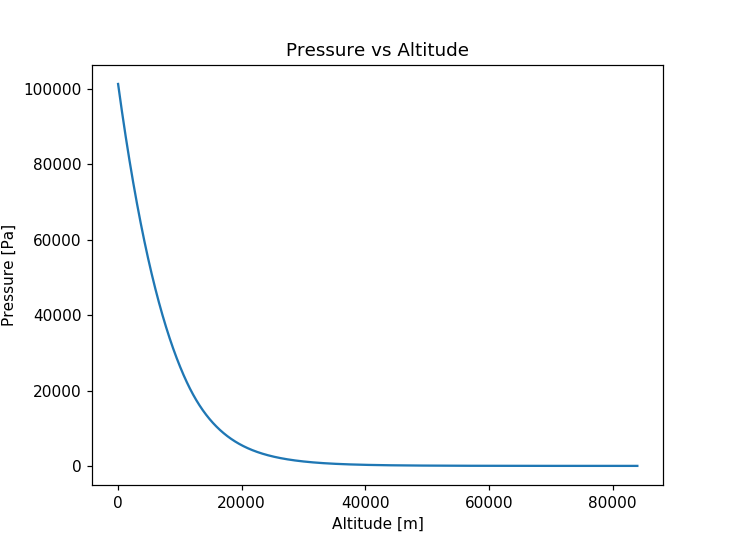

Text(0, 0.5, 'Pressure [Pa]')

In [78]:
plt.plot(tarray, v_P_at_alt(tarray))
plt.title('Pressure vs Altitude')
plt.xlabel('Altitude [m]')
plt.ylabel('Pressure [Pa]')

<IPython.core.display.Javascript object>


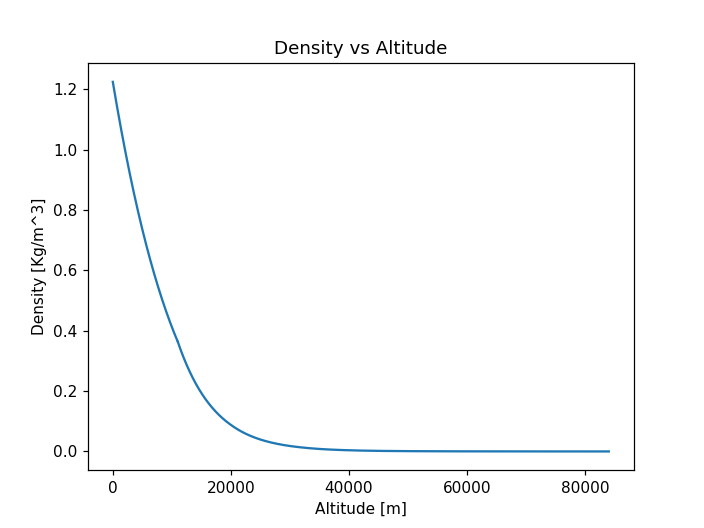

Text(0, 0.5, 'Density [Kg/m^3]')

In [79]:
plt.plot(tarray, v_density_at_alt(tarray))
plt.title('Density vs Altitude')
plt.xlabel('Altitude [m]')
plt.ylabel('Density [Kg/m^3]')